In [2]:
import pandas as pd
# %pip install autoviz
#from autoviz.AutoViz_Class import AutoViz_Class
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, confusion_matrix, classification_report, auc
)
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import shap
from scipy.integrate import trapezoid

In [3]:
pd.set_option('display.max_rows', 100)

In [4]:
pwd()

'c:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionUV\\repos\\Applied-Analytics-Portfolio'

In [5]:
path = "C:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionUV\\kip_sdm_syn.csv"
df = pd.read_csv(path, sep=",")

In [6]:
# Split into train (80%) and test (20%)
df, test_df = train_test_split(df, test_size=0.1, stratify=df["fallen"], random_state=42)

## Dataset Creation One-Hot Encoding

In [7]:
df["transfer"].value_counts()

transfer
2     2016
3      436
4A     166
1       86
4B      10
Name: count, dtype: int64

In [8]:
df['transfer'] = df['transfer'].fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer'])


In [9]:
df["bed_mobility-jones"].value_counts()

bed_mobility-jones
2     1501
3      445
4A     129
1       79
4B       5
Name: count, dtype: int64

In [10]:
df['bed_mobility-jones'] = df['bed_mobility-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-jones'])

In [11]:
df['walk-jones'] = df['walk-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['walk-jones'])

In [12]:
df['decubitus-risk'] = df['decubitus-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-risk'])

In [13]:
df['fall-risk'] = df['fall-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-risk'])

### Always Execute

In [14]:
df["procedure"].dtype

dtype('O')

In [15]:
df["procedure_category"] = df["procedure"].apply(lambda x: x if x == "0" else x.split("-")[0])
df["procedure_category"]


# print(df)

6690     0
35722    1
32809    0
10660    0
33450    8
        ..
8241     1
33347    0
16947    1
7614     3
32409    3
Name: procedure_category, Length: 36000, dtype: object

In [16]:
df["procedure_category"].value_counts()

procedure_category
0    16037
5     6751
1     5377
8     3133
3     2592
9     2043
6       67
Name: count, dtype: int64

In [17]:
df_dummies = pd.get_dummies(df["procedure_category"], prefix="procedure_category")
df_dummies.head()
# # Combine with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-impairment,bed_mobility-skin_condition,...,fall-risk_0,fall-risk_Unknown,procedure_category,procedure_category_0,procedure_category_1,procedure_category_3,procedure_category_5,procedure_category_6,procedure_category_8,procedure_category_9
6690,False,77363,49,0,G453,False,NaN,False,False,NaN,...,True,False,0,True,False,False,False,False,False,False
35722,False,80749,34,1-10,A010,True,NaN,NaN,NaN,NaN,...,False,True,1,False,True,False,False,False,False,False
32809,False,23355,39,0,J110,False,NaN,False,False,NaN,...,False,True,0,True,False,False,False,False,False,False
10660,False,36660,29,0,S100,False,NaN,NaN,NaN,NaN,...,False,True,0,True,False,False,False,False,False,False
33450,False,15012,54,8-92,L210,False,NaN,False,NaN,NaN,...,True,False,8,False,False,False,False,False,True,False


In [18]:
df["diagnosis"]

6690     G453
35722    A010
32809    J110
10660    S100
33450    L210
         ... 
8241     G822
33347    E880
16947    H104
7614     I839
32409    G629
Name: diagnosis, Length: 36000, dtype: object

In [19]:
# Extract the first letter (ICD-10 chapter)
df["ICD10_category"] = df["diagnosis"].str[0]

# One-hot encode the categories
df_dummies = pd.get_dummies(df["ICD10_category"], prefix="ICD10")

# Combine with the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-impairment,bed_mobility-skin_condition,...,ICD10_Q,ICD10_R,ICD10_S,ICD10_T,ICD10_U,ICD10_V,ICD10_W,ICD10_X,ICD10_Y,ICD10_Z
6690,False,77363,49,0,G453,False,NaN,False,False,NaN,...,False,False,False,False,False,False,False,False,False,False
35722,False,80749,34,1-10,A010,True,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
32809,False,23355,39,0,J110,False,NaN,False,False,NaN,...,False,False,False,False,False,False,False,False,False,False
10660,False,36660,29,0,S100,False,NaN,NaN,NaN,NaN,...,False,False,True,False,False,False,False,False,False,False
33450,False,15012,54,8-92,L210,False,NaN,False,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [20]:
df['sex'] = df['sex'].fillna('Unknown')
df = pd.get_dummies(df, columns=['sex'])

In [21]:
df["decubitus-admission"] = df["decubitus-admission"].astype("boolean")
df["decubitus-at_the_moment"] = df["decubitus-at_the_moment"].astype("boolean")
df["bed_mobility-impairment"] = df["bed_mobility-impairment"].astype("boolean")
df["bed_mobility-skin_condition"] = df["bed_mobility-skin_condition"].astype("boolean")
df["transfer-impairment"] = df["transfer-impairment"].astype("boolean")
df["medical_items"] = df["medical_items"].astype("boolean")
df["medical_items-skin_condition_at_item_application"] = df["medical_items-skin_condition_at_item_application"].astype("boolean")
df["fall-last_12_month"] = df["fall-last_12_month"].astype("boolean")
df["fall-while_stay"] = df["fall-while_stay"].astype("boolean")
df["fall-while_transfer"] = df["fall-while_transfer"].astype("boolean")
df["walk-impairment"] = df["walk-impairment"].astype("boolean")
df["excretions-impairment"] = df["excretions-impairment"].astype("boolean")
df["cognition-impairment"] = df["cognition-impairment"].astype("boolean")
df["psychotropic_or_sedatives_drugs"] = df["psychotropic_or_sedatives_drugs"].astype("boolean")
df["diseases"] = df["diseases"].astype("boolean")

### Additional encodings to fix NaNs

In [22]:
df["fall-how_many_last_12_month_missing"] = df["fall-how_many_last_12_month"].isna()

In [23]:
df['fall-while_stay'] = df['fall-while_stay'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-while_stay'])

In [24]:
df['transfer-impairment'] = df['transfer-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer-impairment'])

In [25]:
df['bed_mobility-impairment'] = df['bed_mobility-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-impairment'])

In [26]:
df['excretions-impairment'] = df['excretions-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['excretions-impairment'])

In [27]:
df['cognition-impairment'] = df['cognition-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['cognition-impairment'])

In [28]:
df['walk-impairment'] = df['walk-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['walk-impairment'])

In [29]:
df['fall-while_transfer'] = df['fall-while_transfer'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-while_transfer'])

In [30]:
df['fall-last_12_month'] = df['fall-last_12_month'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-last_12_month'])

In [31]:
df['medical_items-skin_condition_at_item_application'] = df['medical_items-skin_condition_at_item_application'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['medical_items-skin_condition_at_item_application'])

In [32]:
df['medical_items'] = df['medical_items'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['medical_items'])

In [33]:
df['bed_mobility-skin_condition'] = df['bed_mobility-skin_condition'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-skin_condition'])

In [34]:
df['decubitus-at_the_moment'] = df['decubitus-at_the_moment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-at_the_moment'])

In [35]:
df['decubitus-admission'] = df['decubitus-admission'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-admission'])

In [36]:
df['psychotropic_or_sedatives_drugs'] = df['psychotropic_or_sedatives_drugs'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['psychotropic_or_sedatives_drugs'])

In [37]:
df['diseases'] = df['diseases'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['diseases'])

In [38]:
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,...,decubitus-at_the_moment_True,decubitus-at_the_moment_Unknown,decubitus-admission_False,decubitus-admission_Unknown,psychotropic_or_sedatives_drugs_False,psychotropic_or_sedatives_drugs_True,psychotropic_or_sedatives_drugs_Unknown,diseases_False,diseases_True,diseases_Unknown
6690,False,77363,49,0,G453,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
35722,False,80749,34,1-10,A010,True,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
32809,False,23355,39,0,J110,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
10660,False,36660,29,0,S100,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
33450,False,15012,54,8-92,L210,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True


In [39]:
median_value = df["fall-how_many_last_12_month"].median()
df["fall-how_many_last_12_month"] = df["fall-how_many_last_12_month"].fillna(median_value)

In [40]:
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,...,decubitus-at_the_moment_True,decubitus-at_the_moment_Unknown,decubitus-admission_False,decubitus-admission_Unknown,psychotropic_or_sedatives_drugs_False,psychotropic_or_sedatives_drugs_True,psychotropic_or_sedatives_drugs_Unknown,diseases_False,diseases_True,diseases_Unknown
6690,False,77363,49,0,G453,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
35722,False,80749,34,1-10,A010,True,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
32809,False,23355,39,0,J110,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
10660,False,36660,29,0,S100,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,True
33450,False,15012,54,8-92,L210,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True


In [ ]:
import tpot
from sklearn.metrics import average_precision_score
auprc_scorer = make_scorer(average_precision_score, average='macro')

y = df["fallen"]  
X = df.drop(columns=["fallen", "id", "procedure", "diagnosis", "ICD10_category", "procedure_category"]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
est = tpot.TPOTClassifier(scoring=auprc_scorer, max_time_mins=40, verbosity=3, warm_start=True)
est.fit(X_train,y_train)


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


c:\Users\felix\OneDrive\Dokumente\FU_Working\ApplAna\FallPredictionUV\.venv\lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
c:\Users\felix\OneDrive\Dokumente\FU_Working\ApplAna\FallPredictionUV\.venv\lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
32 operators have been imported by TPOT.


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


                                                                             
                                                                             
TPOT closed during evaluation in one generation.
                                                                             
                                                                             
TPOT closed prematurely. Will use the current best pipeline.


TPOTClassifier(max_time_mins=40,
               scoring=make_scorer(average_precision_score, response_method='predict', average=macro),
               verbosity=3)

In [43]:
# Get the final pipeline
print(est.fitted_pipeline_)


Pipeline(steps=[('logisticregression', LogisticRegression(C=10.0))])


In [45]:
# Get model predictions on the test set
y_pred_prob = est.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Calculate the AUPRC
auprc_score = average_precision_score(y_test, y_pred_prob)

print(f"AUPRC Score: {auprc_score}")

AUPRC Score: 0.25797378110868713


In [ ]:

def xgb_pipeline(df):
    """
    Trains and evaluates a Decision Tree model with hyperparameter tuning, 
    finds the best threshold for recall/precision, and visualizes performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.
        target_col (str): Target variable name.
        test_size (float): Train-test split ratio.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Model performance metrics.
    """

    
    # === Load Data ===
    X = df.drop(columns=["fallen", "id", "procedure", "diagnosis", "ICD10_category", "procedure_category"])  # Features
    y = df["fallen"]  # Target  

    # Split train/test sets
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    # === Step 1: Define Model & Parameter Grid ===
    model = xgb.XGBClassifier()

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    }

    # === Step 2: Hyperparameter Tuning using GridSearchCV ===
    grid_search = GridSearchCV(model, param_grid, scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after tuning
    best_classifier = grid_search.best_estimator_

    # Print the best parameters and best score
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")



    # Train a model with the best parameters
    best_classifier.fit(X_train, y_train)

    # Evaluate on test set
    y_pred_best_classifier = best_classifier.predict(X_test)
    print(np.unique(y_pred_best_classifier, return_counts=True))

    print("\nTest set performance with optimized hyperparameters:")
    print(f"Recall: {recall_score(y_test, y_pred_best_classifier):.4f}")
    print(classification_report(y_test, y_pred_best_classifier))


    # === Step 3: Cross-Validation Prediction for Evaluation ===
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(best_classifier, X, y, cv=cv, method="predict_proba")[:, 1]

    

    # === Step 4: Compute AUC-PR ===
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)

    print(f"AUC-PR Score: {auc_pr:.4f}")

    # === Step 5: Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # === Step 6: Histogram of Prediction Probabilities ===
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Predicted Fall Probabilities")
    plt.xlabel("Predicted Probability of Fall (fallen=1)")
    plt.ylabel("Frequency")

    # Apply logarithmic scale to y-axis
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # === Step 7: Find Best Threshold for Recall-Precision Tradeoff ===
    best_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

    # Apply the best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # === Step 8: Confusion Matrix ===
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # === Step 9: Feature Importance ===
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_classifier.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    print("Top 10 Important Features:")
    print(feature_importances.head(30))

    print("Shap Values for the train set")
    explainer = shap.TreeExplainer(best_classifier)
    shap_values_train = explainer(X_train)

    shap.plots.waterfall(shap_values_train[0])

    shap.plots.bar(shap_values_train)
    shap.summary_plot(shap_values_train, X_train, plot_type="bar")

    shap.plots.beeswarm(shap_values_train)

    print("Shap Values for the test set")
    shap_values_test = explainer(X_test)
    shap.plots.waterfall(shap_values_test[0])

    shap.plots.bar(shap_values_test)
    shap.summary_plot(shap_values_test, X_test, plot_type="bar")

    shap.plots.beeswarm(shap_values_test)            


Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best cross-validation recall: 0.1319
(array([0, 1]), array([7197,    3], dtype=int64))

Test set performance with optimized hyperparameters:
Recall: 0.1176
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.67      0.12      0.20        17

    accuracy                           1.00      7200
   macro avg       0.83      0.56      0.60      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.1961
ROC-AUC Score: 0.9907


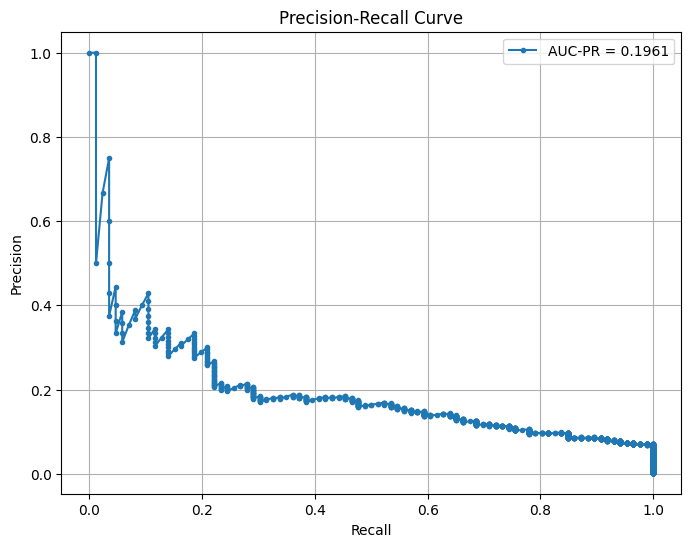

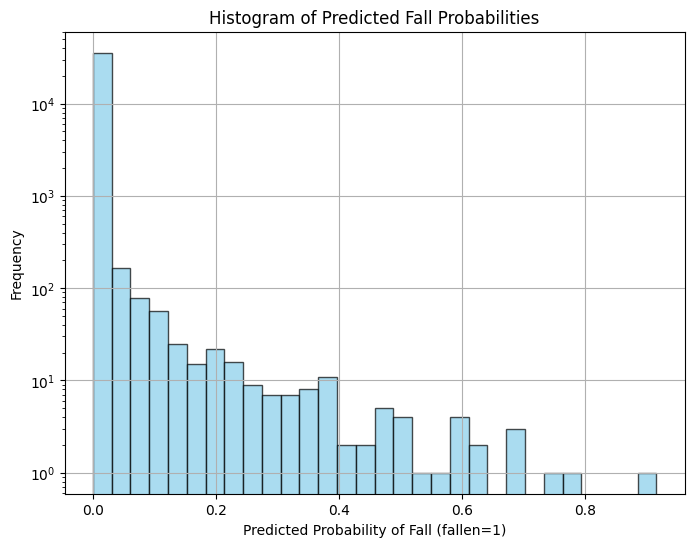

Best Threshold for Precision-Recall Balance: 0.0376


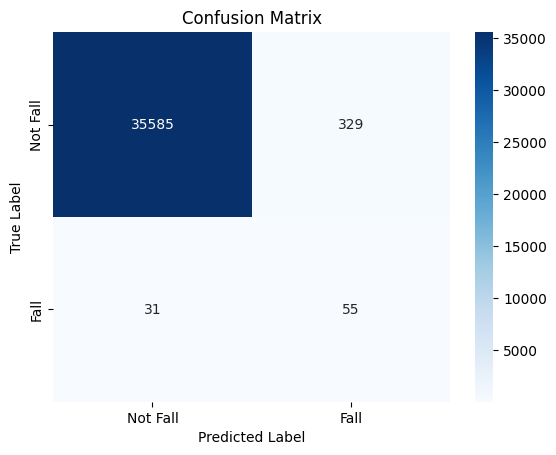

Top 10 Important Features:
                                 Feature  Importance
11        walk-balance_and_gait_impaired    0.401608
83                  fall-while_stay_True    0.030291
42                           fall-risk_+    0.024865
101             fall-while_transfer_True    0.022741
89          bed_mobility-impairment_True    0.017380
60                               ICD10_G    0.013804
110                   medical_items_True    0.011740
115        decubitus-at_the_moment_False    0.011393
85             transfer-impairment_False    0.011378
111                medical_items_Unknown    0.011204
79                            sex_female    0.010961
98                  walk-impairment_True    0.010769
38                      decubitus-risk_+    0.009996
32                          walk-jones_1    0.009718
94            cognition-impairment_False    0.009222
13               excretions-incontinence    0.009189
51                  procedure_category_8    0.008734
124                

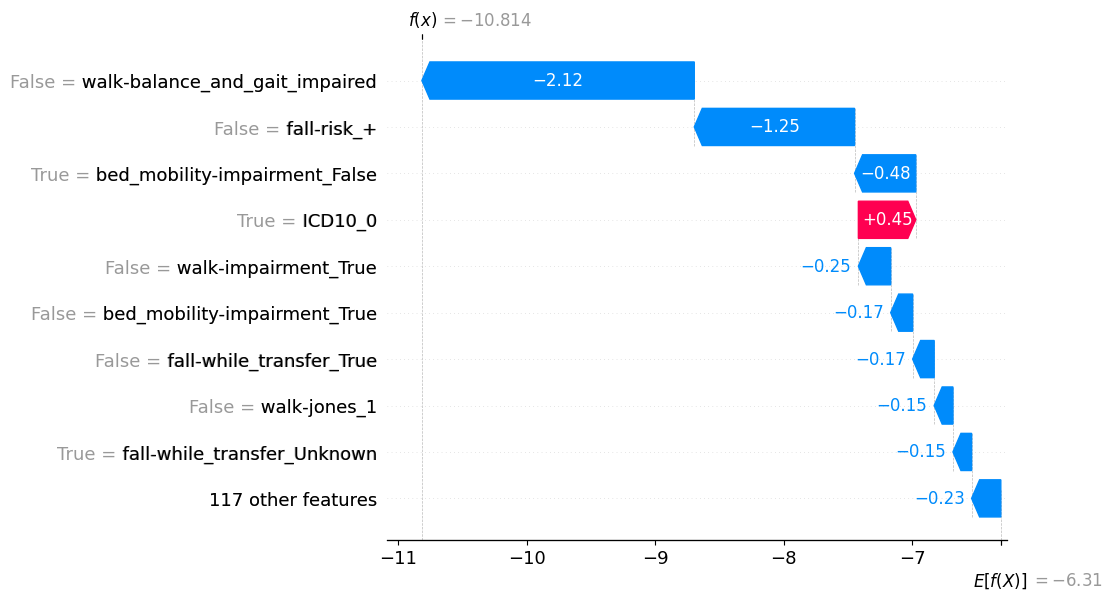

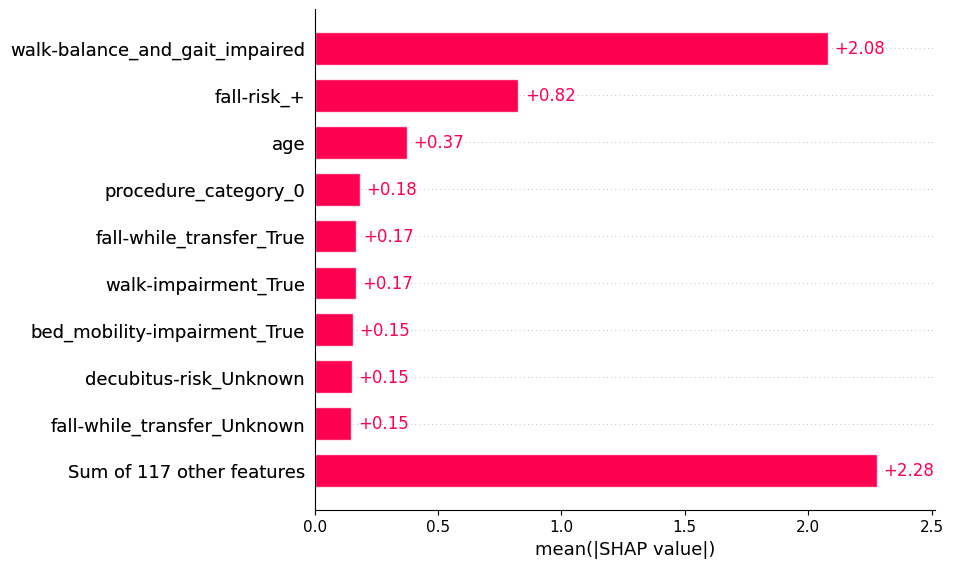

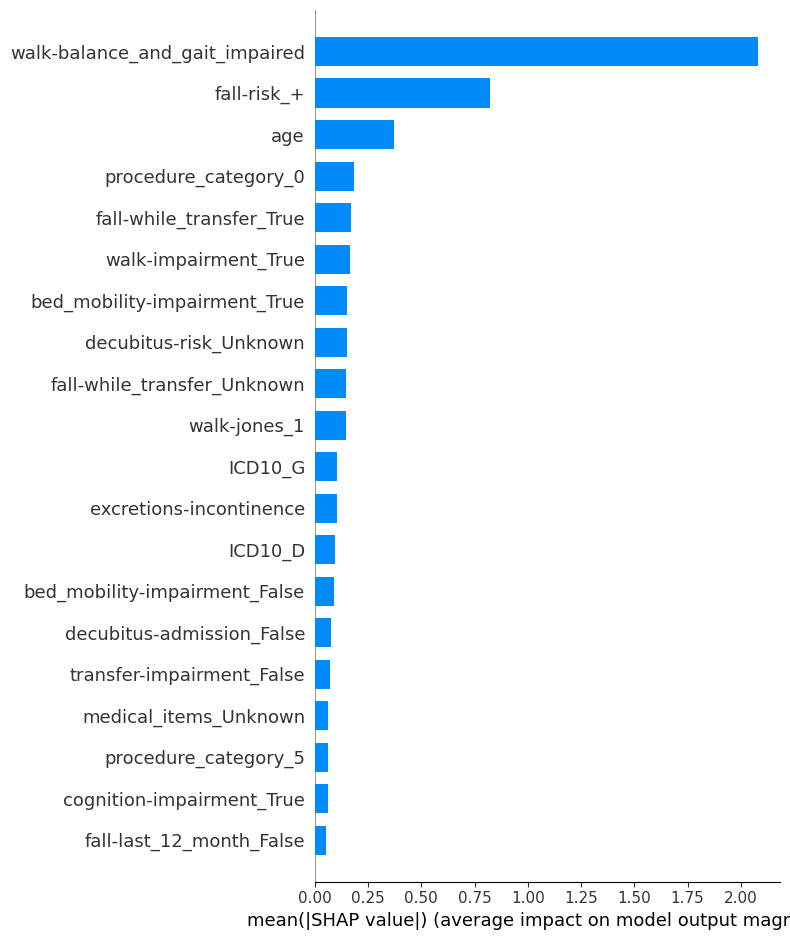

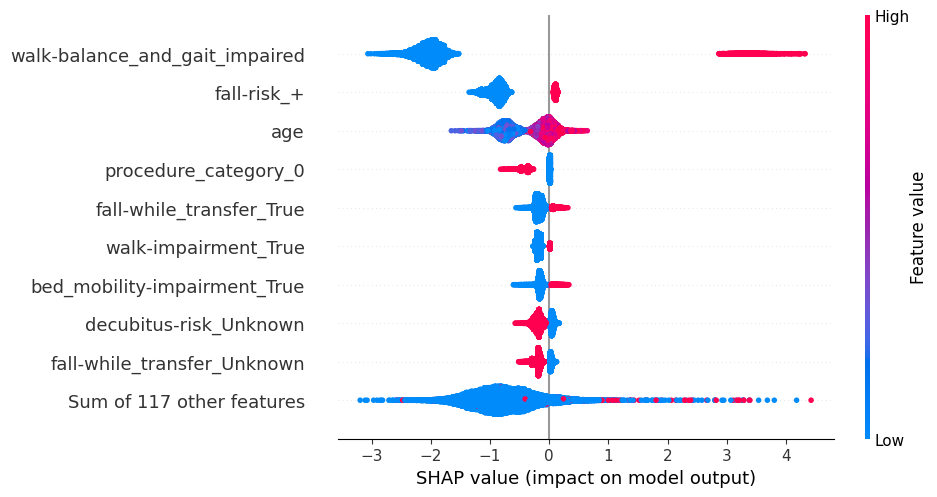

Shap Values for the test set


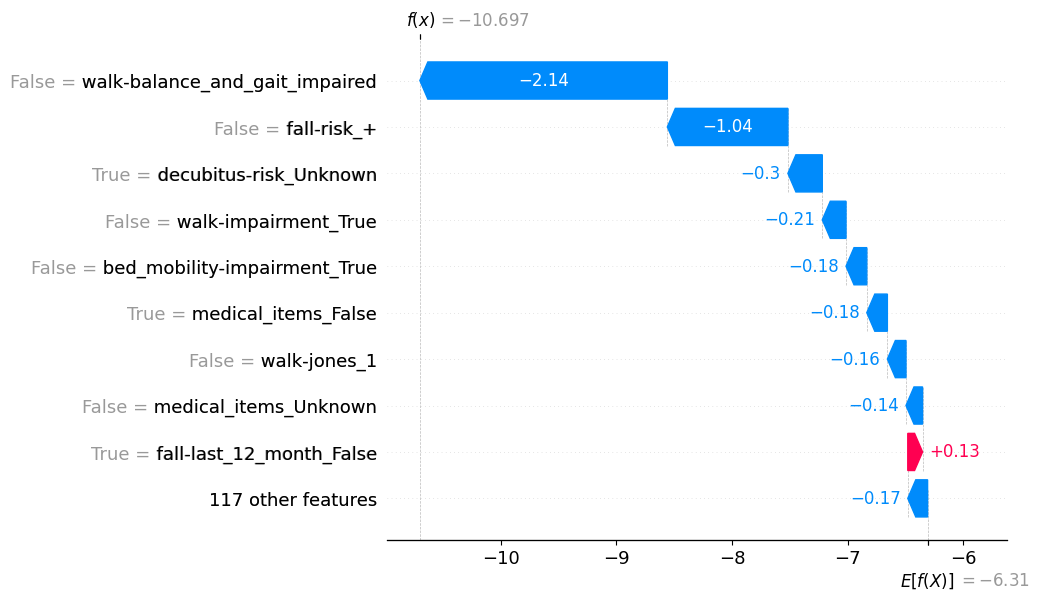

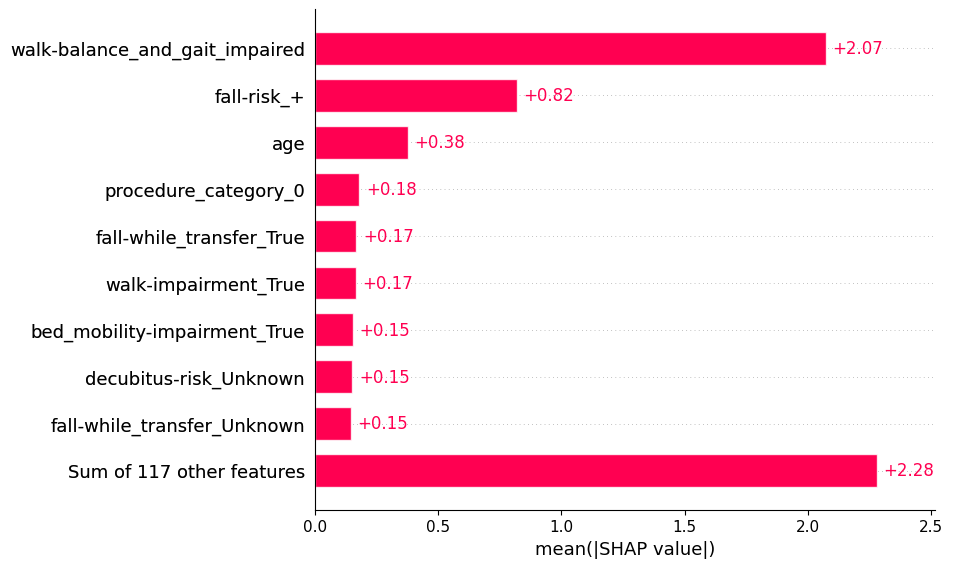

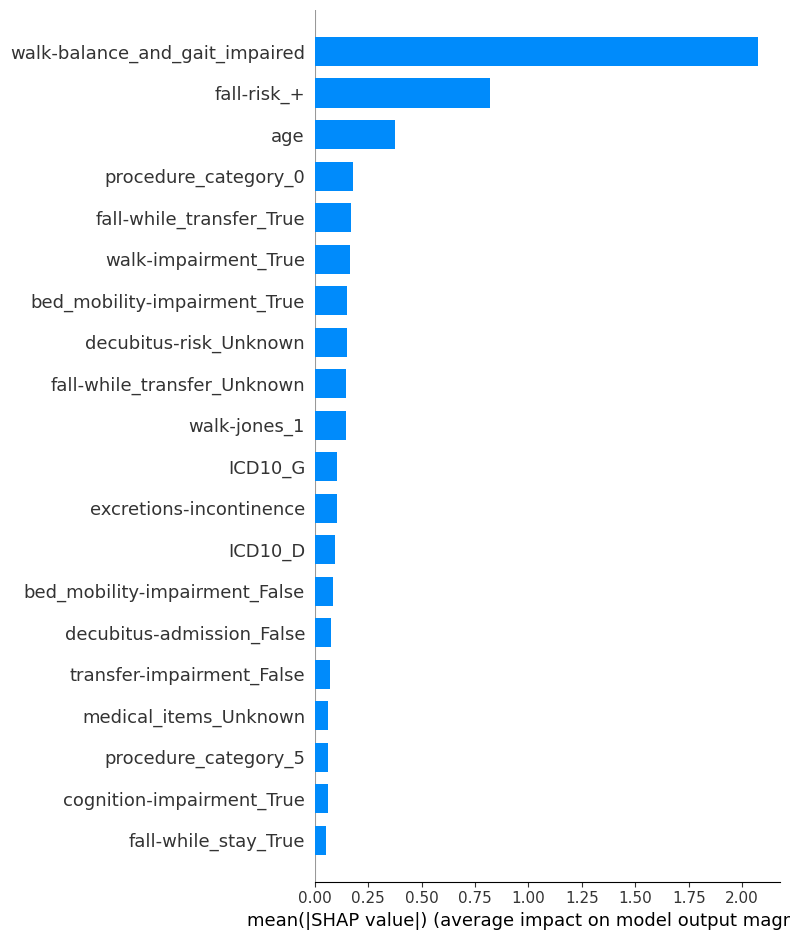

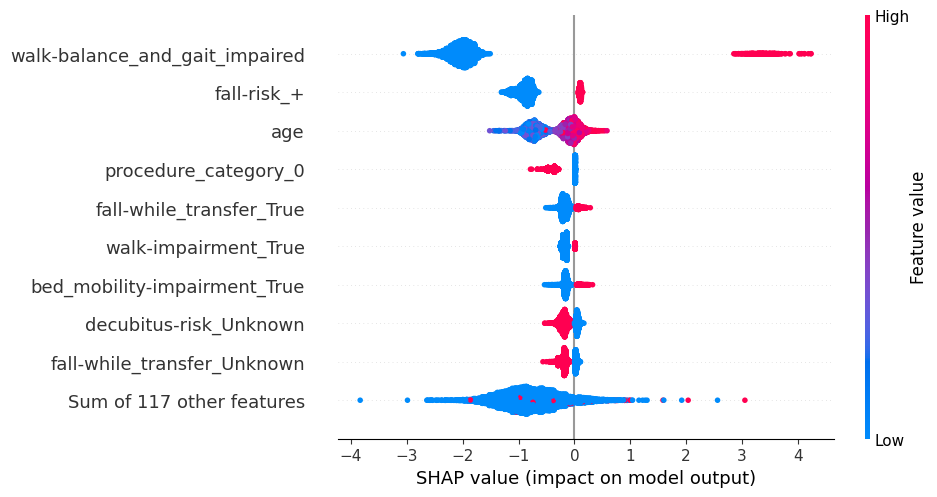

In [54]:
xgb_pipeline(df)

In [56]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model with C=10.0
logreg_model = LogisticRegression(C=10.0, random_state=42)

# Train the model on the training data
logreg_model.fit(X_train, y_train)

# Make predictions (if needed)
y_pred = logreg_model.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import classification_report, average_precision_score

# Get predicted probabilities for the positive class (fallen=1)
y_probs = logreg_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute the AUC-PR score
auc_pr = auc(recall, precision)

# Print the AUC-PR score
print(f"AUC-PR Score: {auc_pr:.4f}")

AUC-PR Score: 0.2281


c:\Users\felix\OneDrive\Dokumente\FU_Working\ApplAna\FallPredictionUV\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
